In [5]:
import pandas as pd 
import numpy as np
!pip install plotnine
!pip install -U scikit-learn

from plotnine import *
from itertools import product
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.4/11.1 MB 13.2 MB/s eta 0:00:01
   ---- ----------------------------------- 1.3/11.1 MB 16.0 MB/s eta 0:00:01
   ------- -------------------------------- 2.0/11.1 MB 15.9 MB/s eta 0:00:01
   ---------- ----------------------------- 2.8/11.1 MB 16.4 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/11.1 MB 17.9 MB/s eta 0:00:01
   ------------------ --------------------- 5.0/11.1 MB 18.9 MB/s eta 0:00:01
   --------------------- ------------------ 6.1/11.1 MB 19.4 MB/s eta 0:00:01
   ------------------------- -------------- 7.2/11.1 MB 20.8 MB/s eta 0:00:01
   ----------------------------- ---------- 8.1/11.1 MB 20.0 MB/s eta 0:00:01
   --------------------------------- ------ 9.3/11.1 MB 20.4 MB/s eta 0:00:01
   ------------------------------------- -- 10.4/11.1 MB 21.8 MB/s eta 0:00:01
   ---------------------------------------  11.1/11.1 MB 21.9 MB/s eta 

In [6]:
def black_scholes_price(S, K, r, T, sigma):
    """Calculate Black Scholes option price."""
  
    d1 = (np.log(S/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    price = S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
    return price

In [7]:
random_state = 42
np.random.seed(random_state)

S = np.arange(164.08, 260.10)
K = np.arange(222.5, 240.0)
r = np.arange(0, 0.051, 0.01)
T = np.arange(3/12, 2.01, 1/12)
sigma = np.arange(0.1, 0.81, 1.1)

option_prices = pd.DataFrame(
  product(S, K, r, T, sigma),
  columns=["S", "K", "r", "T", "sigma"]
)

option_prices["black_scholes"] = black_scholes_price(
  option_prices["S"].values, 
  option_prices["K"].values, 
  option_prices["r"].values, 
  option_prices["T"].values, 
  option_prices["sigma"].values
)

option_prices = (option_prices
  .assign(
    observed_price=lambda x: (
      x["black_scholes"] + np.random.normal(scale=0.15)
    )
  )
)

In [8]:
train_data, test_data = train_test_split(
  option_prices, 
  test_size=0.01, random_state=random_state
)

In [9]:
preprocessor = ColumnTransformer(
  transformers=[(
    "normalize_predictors", 
     StandardScaler(),
     ["S", "K", "r", "T", "sigma"]
  )],
  remainder="drop"
)

In [10]:
max_iter = 1000

nnet_model = MLPRegressor(
  hidden_layer_sizes=10, 
  max_iter=max_iter, 
  random_state=random_state
)

In [11]:
nnet_pipeline = Pipeline([
  ("preprocessor", preprocessor),
  ("regressor", nnet_model)
])

nnet_fit = nnet_pipeline.fit(
  train_data.drop(columns=["observed_price"]), 
  train_data.get("observed_price")
)

In [12]:
rf_model = RandomForestRegressor(
  n_estimators=50, 
  min_samples_leaf=2000, 
  random_state=random_state
)

In [13]:
rf_pipeline = Pipeline([
  ("preprocessor", preprocessor),
  ("regressor", rf_model)
])

rf_fit = rf_pipeline.fit(
  train_data.drop(columns=["observed_price"]), 
  train_data.get("observed_price")
)

In [14]:
deepnnet_model = MLPRegressor(
  hidden_layer_sizes=(10, 10, 10),
  activation="logistic", 
  solver="lbfgs",
  max_iter=max_iter, 
  random_state=random_state
)
                              
deepnnet_pipeline = Pipeline([
  ("preprocessor", preprocessor),
  ("regressor", deepnnet_model)
])

deepnnet_fit = deepnnet_pipeline.fit(
  train_data.drop(columns=["observed_price"]),
  train_data.get("observed_price")
)

c:\Users\Owner\OneDrive\Coding Projects\Project 1\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


In [15]:
lm_pipeline = Pipeline([
  ("polynomial", PolynomialFeatures(degree=5, 
                                    interaction_only=False, 
                                    include_bias=True)),
  ("scaler", StandardScaler()),
  ("regressor", Lasso(alpha=0.01))
])

lm_fit = lm_pipeline.fit(
  train_data.get(["S", "K", "r", "T", "sigma"]),
  train_data.get("observed_price")
)

c:\Users\Owner\OneDrive\Coding Projects\Project 1\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.714e+04, tolerance: 3.134e+03


In [16]:
test_X = test_data.get(["S", "K", "r", "T", "sigma"])
test_y = test_data.get("observed_price")

predictive_performance = (pd.concat(
    [test_data.reset_index(drop=True), 
     pd.DataFrame({"Random forest": rf_fit.predict(test_X),
                   "Single layer": nnet_fit.predict(test_X),
                   "Deep NN": deepnnet_fit.predict(test_X),
                   "Lasso": lm_fit.predict(test_X)})
    ], axis=1)
  .melt(
    id_vars=["S", "K", "r", "T", "sigma",
             "black_scholes", "observed_price"],
    var_name="Model",
    value_name="Predicted"
  )
  .assign(
    moneyness=lambda x: x["S"]-x["K"],
    pricing_error=lambda x: np.abs(x["Predicted"]-x["black_scholes"])
  )
)

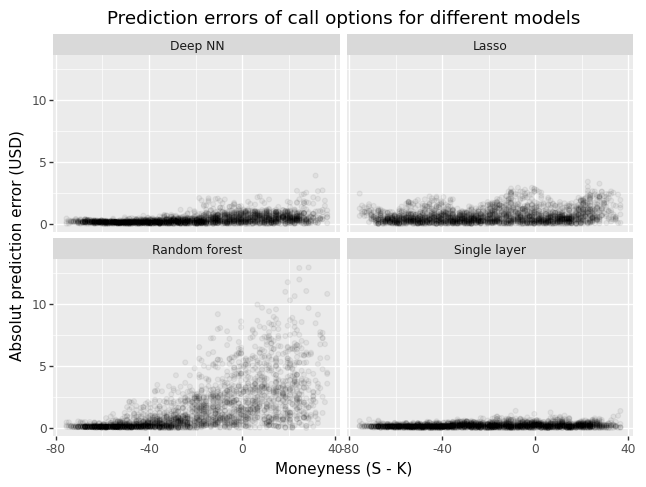

In [17]:
predictive_performance_plot = (
  ggplot(predictive_performance, 
         aes(x="moneyness", y="pricing_error")) +
  geom_point(alpha=0.05) +
  facet_wrap("Model") + 
  labs(x="Moneyness (S - K)", y="Absolut prediction error (USD)",
       title="Prediction errors of call options for different models") +
  theme(legend_position="")
)
predictive_performance_plot.draw()